# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [5]:
train.isnull().sum()

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [6]:
test.isnull().sum()

id            0
keyword      17
location    773
text          0
target        0
dtype: int64

In [7]:
train.fillna('', inplace=True)
test.fillna('', inplace=True)

In [8]:
train.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [9]:
test.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [10]:
train[train['target'] == 0].shape[0], train[train['target'] == 1].shape[0]

(3024, 2305)

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [11]:
popular_keywords = train['keyword'].value_counts()[1:11].index.tolist()

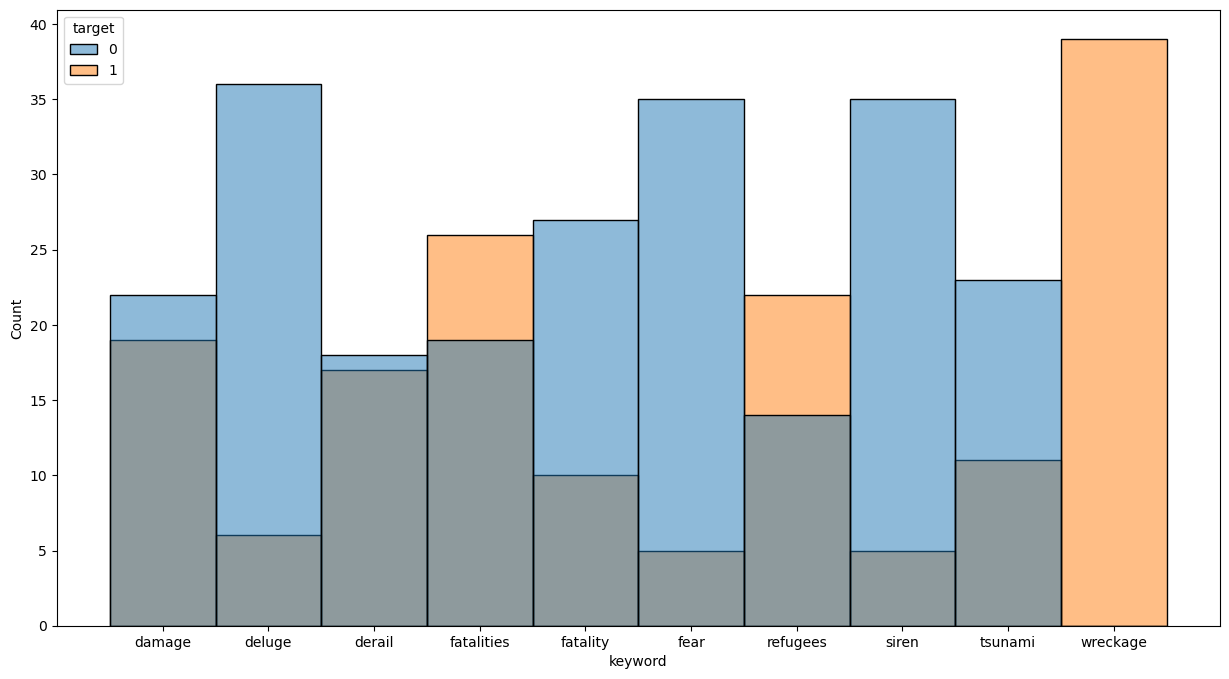

In [12]:
plt.figure(figsize=(15, 8))
sns.histplot(data[data['keyword'].isin(popular_keywords)], x='keyword', hue="target")
plt.show()

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [13]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [14]:
train_new = train.copy()
train_new["text"] = train_new[["keyword", "location", "text"]].apply(" ".join, axis=1)
del train_new['id']
del train_new['keyword']
del train_new['location']

In [15]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


In [16]:
test_new = test.copy()
test_new["text"] = test_new[["keyword", "location", "text"]].apply(" ".join, axis=1)
del test_new['id']
del test_new['keyword']
del test_new['location']

## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [17]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(train_new.text)

In [18]:
pd.DataFrame(X.toarray(), columns=cnt_vec.get_feature_names_out()).shape

(5329, 18455)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [19]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return any(char.isdigit() for char in s)

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    import string
    return any(char in string.punctuation for char in s)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s[0] == '#'

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s[0] == '@'

def investigate_vocabulary(vocabulary):
    dg, pnct, hstg, mntn = 0, 0, 0, 0
    for s in vocabulary:
        if contains_digit(s):
            dg += 1
        if contains_punctuation(s):
            pnct += 1
        if is_hashtag(s):
            hstg +=1
        if is_mention(s):
            mntn += 1
    print('With digit:      ', dg
          )
    print('With punctuation:', pnct
          )
    print('Hashtags:        ', hstg
          )
    print('Mentions:        ', mntn
          )




In [20]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [21]:
investigate_vocabulary(cnt_vec.vocabulary_)

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [22]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [23]:
tw = TweetTokenizer()
texts_tokenized = [
    " ".join([w for w in tw.tokenize(t)]) for t in train_new.text
]

In [24]:
cnt_vec2 = CountVectorizer()
X_tok = cnt_vec2.fit_transform(texts_tokenized)

In [25]:
investigate_vocabulary(cnt_vec2.vocabulary_)

With digit:       3759
With punctuation: 311
Hashtags:         0
Mentions:         0


**Сравнение:** В результате применения токенизатора количество слов с мусором уменьшилось, но довольно незначительно 

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [26]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return s.isalpha()

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    import string
    return all(char in string.punctuation for char in s) and (')' in s or '(' in s)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s[0] == '#'

def custom_tokenizer(s: str) -> List[str]:    
    # Кастомный токенайзер
    from nltk.corpus import stopwords
    from nltk.stem.snowball import SnowballStemmer
    s = s.lower()
    s_tokenized = tw.tokenize(s)
    text_tokenized = []
    for token in s_tokenized:
        if token in stopwords.words("english"):
            continue
        if contains_only_latin_letters(token) or (is_hashtag(token) and contains_only_latin_letters(token[1:])) or is_emoji(token):
            text_tokenized.append(token)
    stemmer = SnowballStemmer("english")
    text_stemmed = [stemmer.stem(w) for w in text_tokenized]
    return text_stemmed

In [27]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [28]:
for text in train_new.head(10).text.apply(custom_tokenizer):
    print (text)

['bridg', 'ash', 'australia', 'ûªs', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']
['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'beach', 'run', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee']
['airplan', 'somewher', 'expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', 'french', 'air', 'accid', 'expert', '#mlb']
['bloodi', 'isol', 'citi', 'world', 'perth', 'came', 'kill', 'indian', 'fun', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast']
['burn', 'except', 'idk', 'realli', 'burn']
['destroy', '(', 'ask', ')', 'destroy', 'hous']
['wound', 'maracay', 'nirgua', 'venezuela', 'polic', 'offic', 'wound', '

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [29]:
x_train, y_train = train_new.text, train_new.target
x_test, y_test = test_new.text, test_new.target

In [30]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
bow_train = vectorizer.fit_transform(x_train)
bow_test = vectorizer.transform(x_test)

2. Обучите LogisticRegression на полученных признаках.


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import classification_report

scaler = MaxAbsScaler()
bow_train = scaler.fit_transform(bow_train)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow_train, y_train)
pred = clf.predict(bow_test)

3. Посчитайте метрику f1-score на тестовых данных.

In [32]:
from sklearn.metrics import f1_score

f1_score(y_test, pred)

0.7432057681641709

## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
vec_train = vectorizer.fit_transform(x_train)
vec_test = vectorizer.transform(x_test)

In [34]:
pd.DataFrame(vec_train.toarray(), columns=vectorizer.get_feature_names_out()).shape

(5329, 10591)

In [35]:
scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)

In [36]:
f1_score(y_test, pred_tfidf)

0.7422343324250681

1. **Ответ:** Каечство практически не изменилось (но стало чуть меньше)

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [37]:
vectorizer1 = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
vec_train = vectorizer1.fit_transform(x_train)
vec_test = vectorizer1.transform(x_test)

pd.DataFrame(vec_train.toarray(), columns=vectorizer1.get_feature_names_out()).shape

(5329, 10591)

In [38]:
scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)

In [39]:
f1_score(y_test, pred_tfidf)

0.7422343324250681

2. **Ответ:** Ни размер матрицы, ни качество не изменились

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [40]:
vectorizer2 = TfidfVectorizer(tokenizer=custom_tokenizer, min_df=0.01)
vec_train = vectorizer2.fit_transform(x_train)
vec_test = vectorizer2.transform(x_test)

pd.DataFrame(vec_train.toarray(), columns=vectorizer2.get_feature_names_out()).shape

(5329, 128)

In [41]:
scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)

In [42]:
f1_score(y_test, pred_tfidf)

0.626951995373048

3. **Ответ:** При довольно малом минимальном df размер матрицы уменьшился, качество стало ниже

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [43]:
from sklearn.feature_extraction.text import HashingVectorizer

# -- YOUR CODE HERE --
print('F1 score: *YOUR SCORE*')

F1 score: *YOUR SCORE*


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** TODO

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [44]:
# -- YOUR CODE HERE --